## Path to Source

In [1]:
# load local version before pip installed version, for debugging
import sys
import pathlib

sys.path.append(pathlib.Path(__file__).parent.parent.joinpath("src"))

## Imports

In [2]:
import numpy as np
import yt
import matplotlib.pyplot as plt

from gallifrey.data.load import load_snapshot
from gallifrey.halo import MainHalo
from gallifrey.utilities.time import Timer

from gallifrey.filter import Filter
from gallifrey.fields import Fields

## Load Data

In [3]:
snapshot = 127
resolution = 4096
sim_id = "09_18"

In [4]:
ds = load_snapshot(snapshot, resolution)
mw = MainHalo("MW", resolution, ds, sim_id=sim_id)


      DETECTED LOCAL MACHINE: Test snapshot loaded.

yt : [INFO     ] 2023-03-09 15:14:34,562 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-03-09 15:14:34,629 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-03-09 15:14:34,631 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-03-09 15:14:34,632 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-03-09 15:14:34,632 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-03-09 15:14:34,633 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-03-09 15:14:34,633 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-03-09 15:14:34,634 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-03-09 15:14:34,634 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-03-09 15:14:34,634 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 202

## Add Filters and Fields

In [5]:
filters = Filter(ds)
filters.add_stars()

fields = Fields(ds)
fields.add_stellar_age()

yt : [INFO     ] 2023-03-09 15:14:34,844 Allocating for 1.920e+08 particles
Loading particle index: 100%|███████████████| 245/245 [00:00<00:00, 3699.16it/s]


## Plots Settings

In [6]:
# save or show figure
mode = 'show'

def show_or_save(plot, mode):
    if mode == 'save':
        plot.save()
    elif mode == 'show':
        plot.show()
    else:
        raise ValueError('Mode not known')

In [7]:
# map settings
gas_projection_dict = {'ds':ds, 'normal':'z', 'data_source':mw.sphere(radius=(55,'kpc')), 'center':mw.centre(), 'width':(55,'kpc')}
particle_projection_dict = {'ds':ds, 'axis':'z', 'data_source':mw.sphere(radius=(55,'kpc')), 'center':mw.centre(), 'width':(55,'kpc'), 'deposition':'cic'}

## Metallicity

### Maps

yt : [INFO     ] 2023-03-09 15:14:35,631 xlim = 69017.183488 69072.183488
yt : [INFO     ] 2023-03-09 15:14:35,631 ylim = 72371.296075 72426.296075
yt : [INFO     ] 2023-03-09 15:14:35,632 xlim = 46.772939 46.810212
yt : [INFO     ] 2023-03-09 15:14:35,633 ylim = 49.046021 49.083294
yt : [INFO     ] 2023-03-09 15:14:35,637 Making a fixed resolution buffer of (('gas', 'metallicity')) 800 by 800
yt : [INFO     ] 2023-03-09 15:14:43,323 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



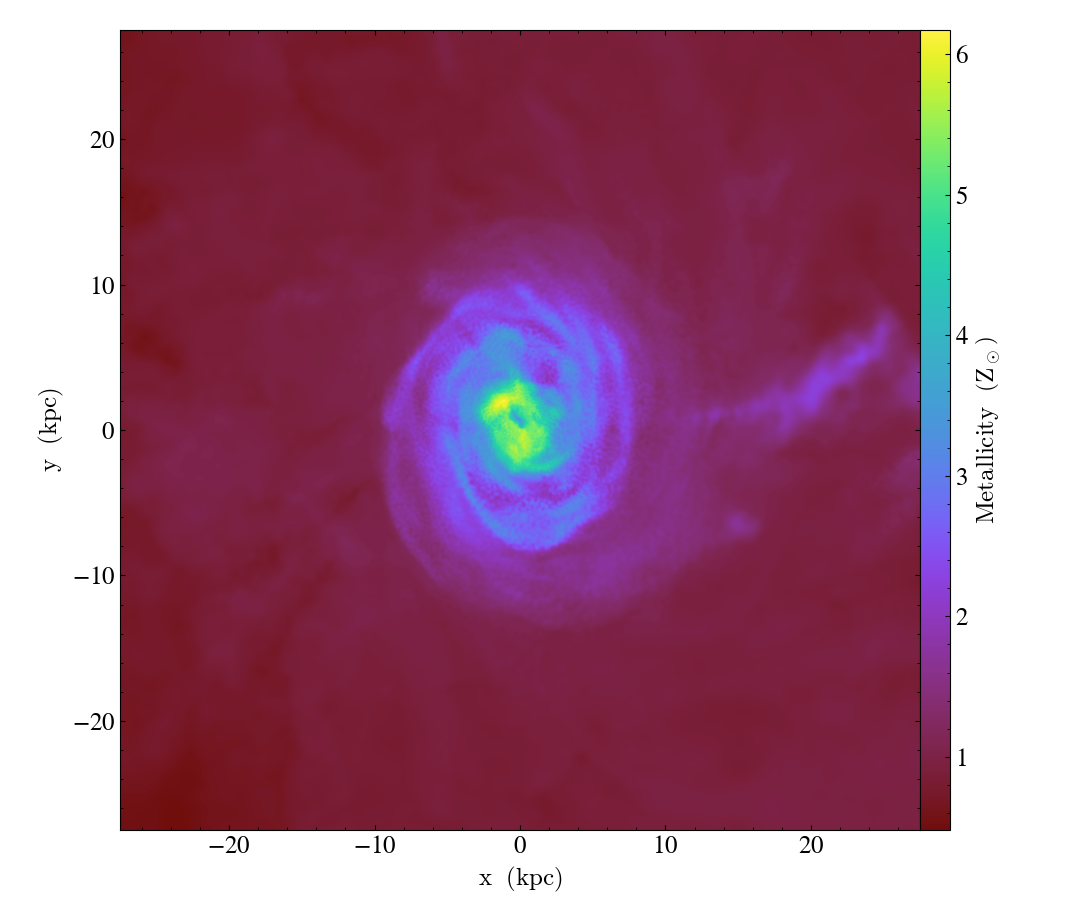

In [8]:
# gas density-weighted gas metallicity
plot = yt.ProjectionPlot(
    fields=("gas", "metallicity"),
    weight_field=("gas", "density"),
    **gas_projection_dict,
)

plot.set_unit(("gas", "metallicity"), "Zsun")
plot.set_log(("gas", "metallicity"), False)
show_or_save(plot, mode)

yt : [INFO     ] 2023-03-09 15:14:50,172 xlim = 69017.183488 69072.183488
yt : [INFO     ] 2023-03-09 15:14:50,173 ylim = 72371.296075 72426.296075
yt : [INFO     ] 2023-03-09 15:14:50,174 xlim = 69017.183488 69072.183488
yt : [INFO     ] 2023-03-09 15:14:50,174 ylim = 72371.296075 72426.296075
yt : [INFO     ] 2023-03-09 15:14:50,176 Splatting (('stars', 'metallicity')) onto a 800 by 800 mesh using method 'cic'



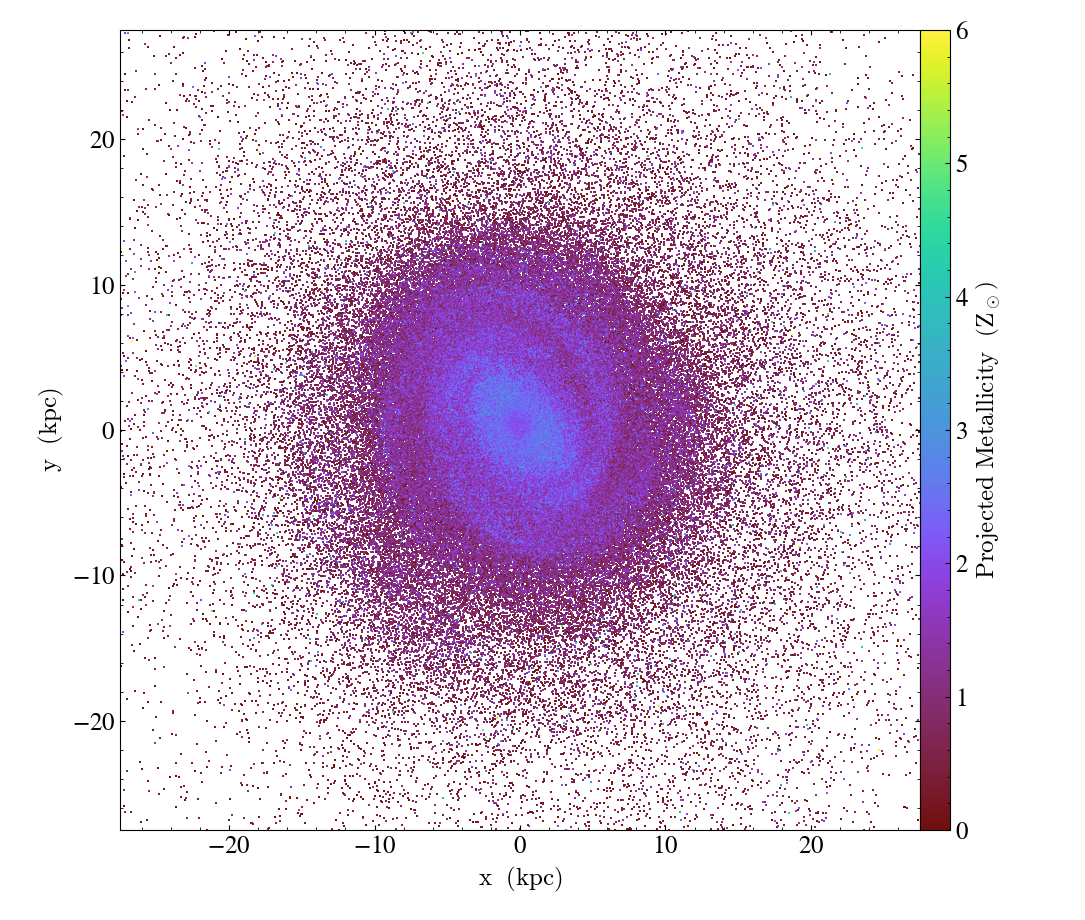

In [9]:
# average stellar metallicities
plot = yt.ParticleProjectionPlot(
    fields=("stars", "metallicity"),
    weight_field=("stars", "particle_ones"),
    **particle_projection_dict,
)
plot.set_unit(("stars", "metallicity"), "Zsun")
plot.set_log(("stars", "metallicity"), False)
plot.set_zlim(("stars", "metallicity"), zmin=(0, "Zsun"), zmax=(6, "Zsun"))
show_or_save(plot, mode)

### Profiles


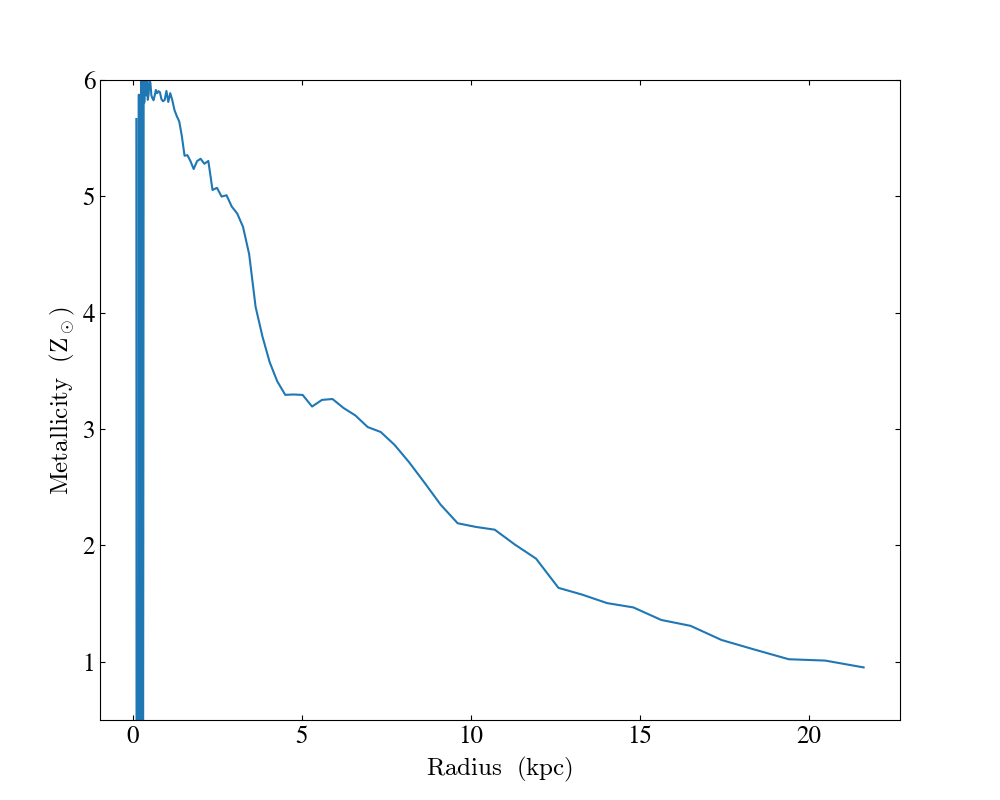

In [10]:
# density-weighted gas metallicity
gas_profile = yt.create_profile(
    data_source=mw.disk(radius=ds.quan(20,'kpc')),
    bin_fields=[("gas", "radius")],
    fields=[("gas", "metallicity")],
    n_bins=100,
    units={('gas', 'radius'): 'kpc', ('gas','metallicity'): 'Zsun'},
    weight_field=('gas', 'density'),
)

plot = yt.ProfilePlot.from_profiles(gas_profile)
plot.set_log(("gas", "radius"), False)
plot.set_log(("gas", "metallicity"), False)
plot.set_ylim(('gas','metallicity'),0.5, 6)
show_or_save(plot, mode)


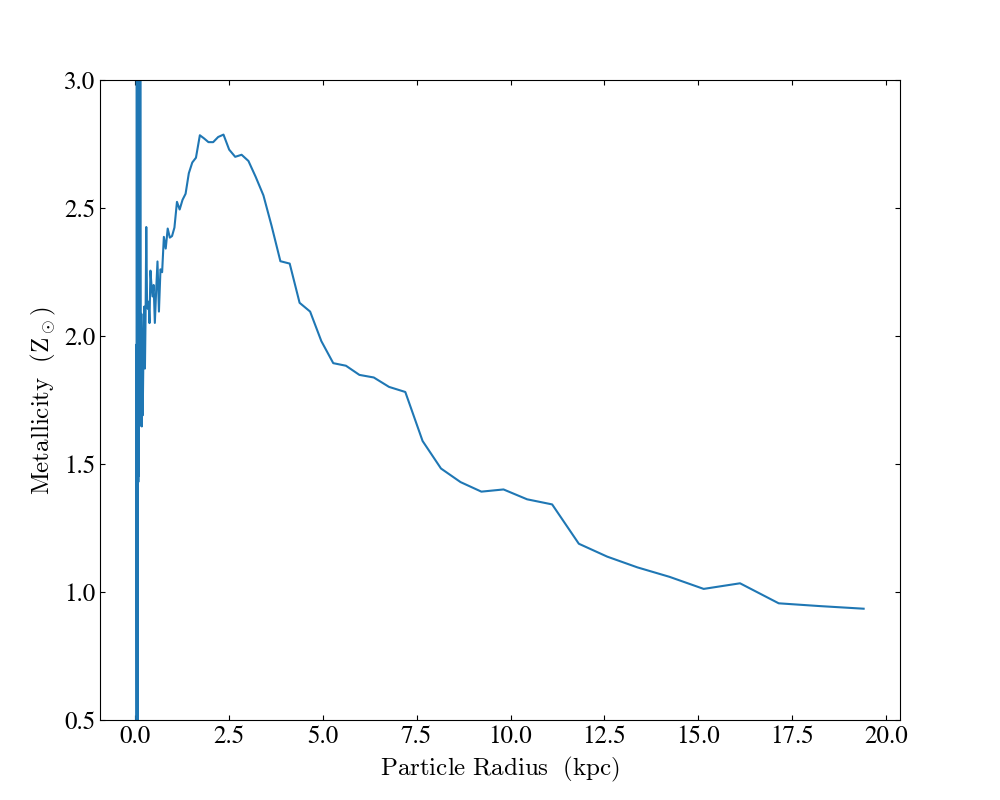

In [11]:
# average stellar metallicity profile
star_profile = yt.create_profile(
    data_source=mw.disk(radius=ds.quan(20,'kpc')),
    bin_fields=[("stars", "particle_radius")],
    fields=[("stars", "metallicity")],
    n_bins=100,
    units={('stars', 'particle_radius'): 'kpc', ('stars','metallicity'): 'Zsun'},
    weight_field=('stars', 'particle_ones'),
)

plot = yt.ProfilePlot.from_profiles(star_profile)
plot.set_log(('stars', 'particle_radius'), False)
plot.set_log(('stars','metallicity'), False)
plot.set_ylim(('stars','metallicity'),0.5, 3)
show_or_save(plot, mode)

/tmp/ipykernel_24221/3393994826.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


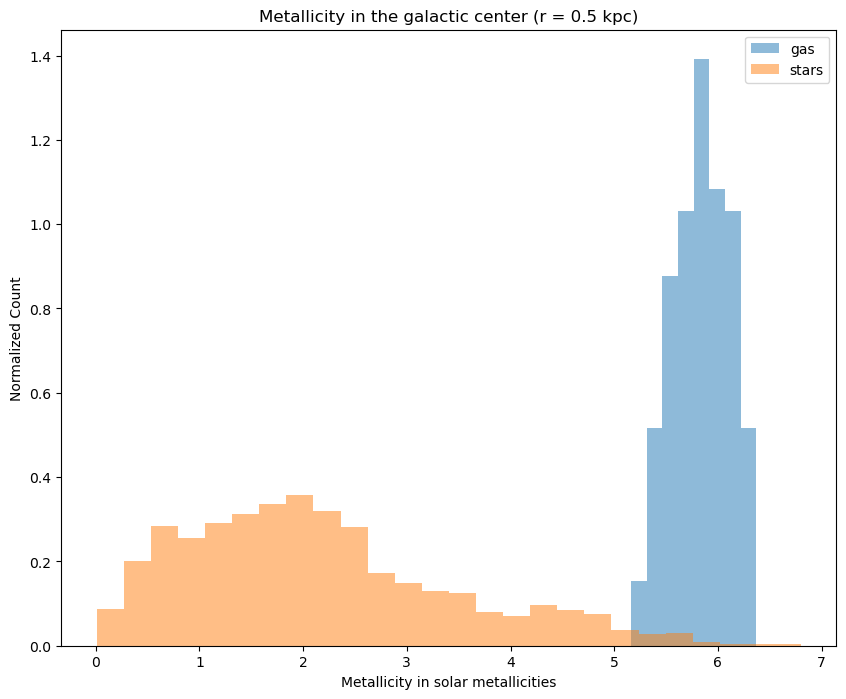

In [12]:
# metallicity histogram - galactic center
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(mw.sphere(radius=ds.quan(0.5,'kpc'))['gas','metallicity'].to('Zsun').value, density=True, bins='fd', label='gas', alpha=0.5)
ax.hist(mw.sphere(radius=ds.quan(0.5,'kpc'))['stars','metallicity'].to('Zsun').value, density=True, bins='fd', label='stars', alpha=0.5)
ax.set_xlabel('Metallicity in solar metallicities')
ax.set_ylabel('Normalized Count')
ax.set_title('Metallicity in the galactic center (r = 0.5 kpc)')
ax.legend()
show_or_save(fig, mode)

/tmp/ipykernel_24221/3393994826.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


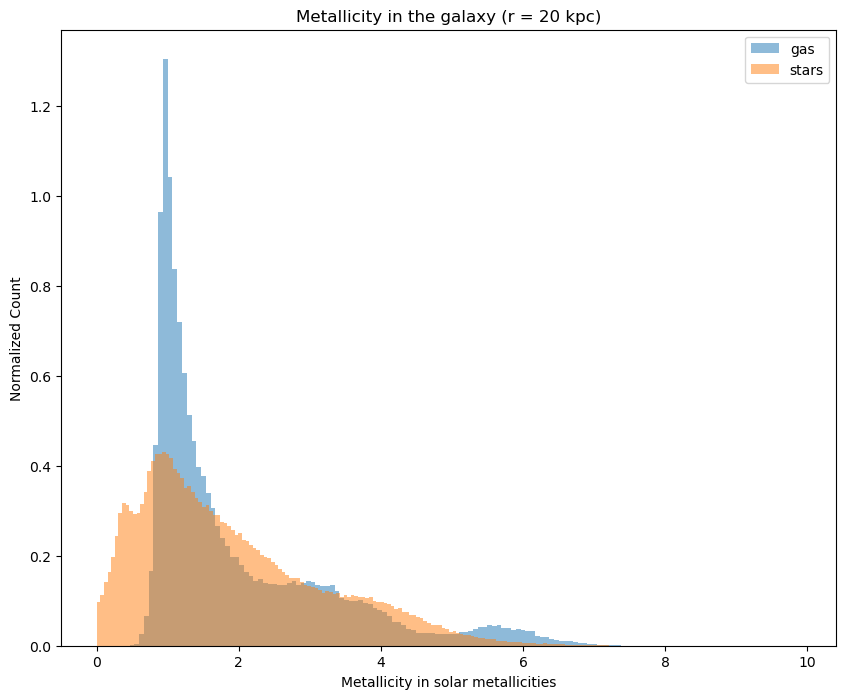

In [13]:
# metallicity histogram - 20kpc
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(mw.sphere(radius=ds.quan(20,'kpc'))['gas','metallicity'].to('Zsun').value, density=True, bins='fd', label='gas', alpha=0.5)
ax.hist(mw.sphere(radius=ds.quan(20,'kpc'))['stars','metallicity'].to('Zsun').value, density=True, bins='fd', label='stars', alpha=0.5)
ax.set_xlabel('Metallicity in solar metallicities')
ax.set_ylabel('Normalized Count')
ax.set_title('Metallicity in the galaxy (r = 20 kpc)')
ax.legend()
show_or_save(fig, mode)

# Stellar Age

yt : [INFO     ] 2023-03-09 15:15:35,344 xlim = 69017.183488 69072.183488
yt : [INFO     ] 2023-03-09 15:15:35,345 ylim = 72371.296075 72426.296075
yt : [INFO     ] 2023-03-09 15:15:35,346 xlim = 69017.183488 69072.183488
yt : [INFO     ] 2023-03-09 15:15:35,346 ylim = 72371.296075 72426.296075
yt : [INFO     ] 2023-03-09 15:15:35,347 Splatting (('stars', 'stellar_age')) onto a 800 by 800 mesh using method 'cic'



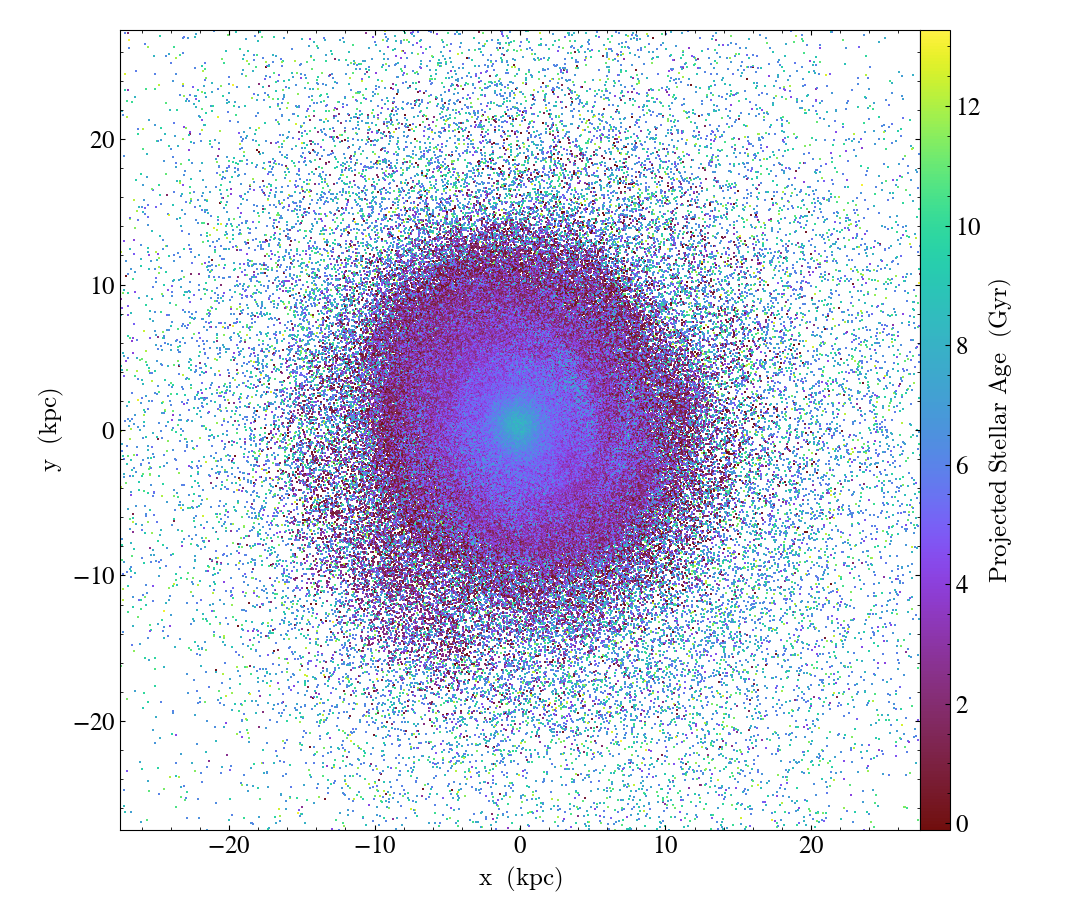

In [14]:
# average stellar metallicities
plot = yt.ParticleProjectionPlot(
    fields=("stars", "stellar_age"),
    weight_field=("stars", "particle_ones"),
    **particle_projection_dict,
)
#plot.set_unit(("PartType4", "stellar_age"), "Gyr")
plot.set_log(("stars", "stellar_age"), False)
#plot.set_zlim(("PartType4", "metallicity"), zmin=(0, "Zsun"), zmax=(6, "Zsun"))
show_or_save(plot, mode)


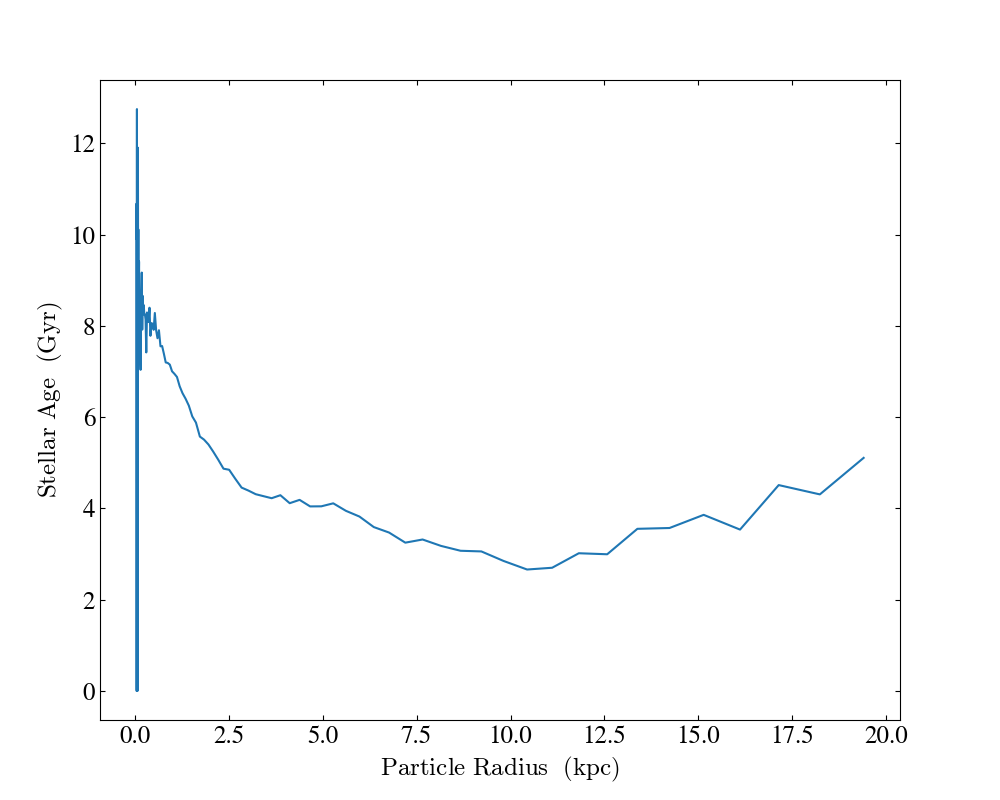

In [15]:
# average stellar age profile
star_profile = yt.create_profile(
    data_source=mw.disk(radius=ds.quan(20,'kpc')),
    bin_fields=[("stars", "particle_radius")],
    fields=[("stars", "stellar_age")],
    n_bins=100,
    units={('stars', 'particle_radius'): 'kpc', ('stars','stellar_age'): 'Gyr'},
    weight_field=('stars', 'particle_ones'),
)

plot = yt.ProfilePlot.from_profiles(star_profile)
plot.set_log(('stars', 'particle_radius'), False)
plot.set_log(('stars','stellar_age'), False)
show_or_save(plot, mode)